### Real-world example: Spawning salmon

That was contrived data; let's try applying Gaussian processes to a real problem. The plot below shows the relationship between the number of spawning salmon in a particular stream and the number of fry that are recruited into the population in the spring.

We would like to model this relationship, which appears to be non-linear (we have biological knowledge that suggests it should be non-linear too).

![](images/spawn.jpg)

In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

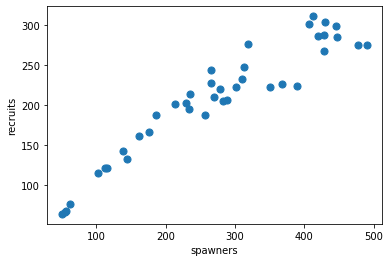

In [4]:
salmon_data = pd.read_table('../data/salmon.txt', sep='\s+', index_col=0)
salmon_data.plot.scatter(x='spawners', y='recruits', s=50);

In [5]:
with pm.Model() as salmon_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 3)
    η = pm.HalfCauchy('η', 3)
    
    M = pm.gp.mean.Linear(coeffs=(salmon_data.recruits/salmon_data.spawners).mean())
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfCauchy('σ', 1)
    
    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood('recruits', X=salmon_data.spawners.values.reshape(-1,1), 
                           y=salmon_data.recruits.values, noise=σ)
    

/Users/cfonnesbeck/anaconda3/envs/dev/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [7]:
with salmon_model:
    salmon_trace = pm.sample(1000, tune=2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ρ]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:19<00:00, 315.24draws/s]
The number of effective samples is smaller than 25% for some parameters.


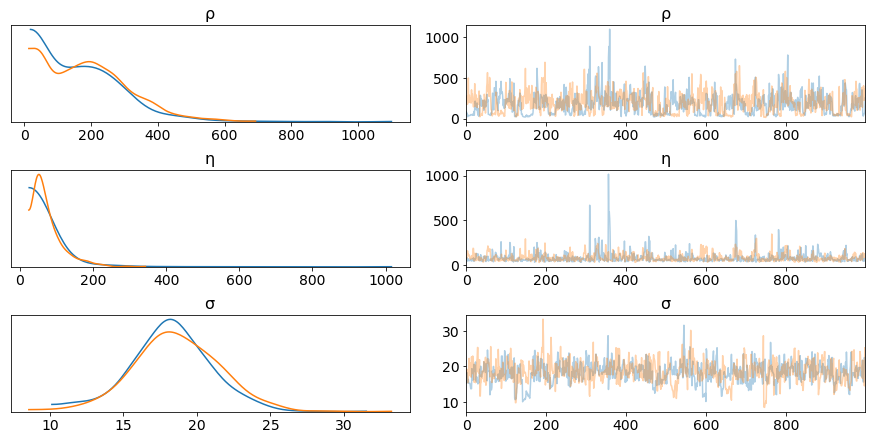

In [10]:
az.plot_trace(salmon_trace, var_names=['ρ', 'η', 'σ']);

In [13]:
X_pred = np.linspace(0, 500, 100).reshape(-1, 1)

with salmon_model:
    salmon_pred = recruit_gp.conditional("salmon_pred", X_pred)
    salmon_samples = pm.sample_posterior_predictive(salmon_trace, vars=[salmon_pred], samples=3, random_seed=42)

100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


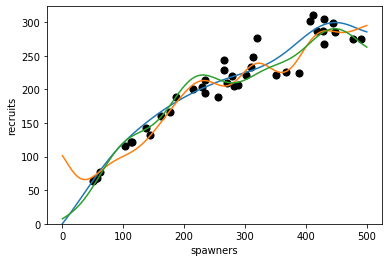

In [14]:
ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for x in salmon_samples['salmon_pred']:
    ax.plot(X_pred, x);

### Exercise

We might be interested in what may happen if the population gets very large -- say, 600 or 800 spawners. We can predict this, though it goes well outside the range of data that we have observed. Generate predictions from the posterior predictive distribution (via `conditional`) that covers this range of spawners.

In [37]:
# Write answer here